## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

- 1. [Подготовка](#the_destination01)
- 2. [Анализ](#the_destination02)
- 3. [Подготовка](#the_destination03)
- 4. [Обучение](#the_destination04)
    - 3.1 [Ridge](#the_destination05)
    - 3.2 [SVM](#the_destination06)
    - 3.3 [KNN](#the_destination07)
    - 3.4 [Random Forest](#the_destination08)
    - 3.5 [Light GBM](#the_destination09)
    - 3.6 [Dummy](#the_destination10)
- 5. [Вывод](#the_destination11)

# 1. Подготовка<a id='the_destination01'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv('/datasets/taxi.csv')

state = np.random.RandomState(21)

np.set_printoptions(precision=3)
sns.set()

Функция `column_info` показывает информацию по столбцу.

In [2]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=50):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print()
    print('*** Информация по столбцу {} ***'.format(column))
    print()
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {:.2f}'.format(data[column].min()))
        print('Максимальное значение: {:.2f}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {:.2f}'.format(data[column].median()))
        if hist:
            gridsize = (5, 1)
            fig = plt.figure(figsize=(15, 5))
            ax1 = plt.subplot2grid(gridsize, (0, 0))
            ax2 = plt.subplot2grid(gridsize, (1, 0), rowspan=4)                       
            sns.boxplot(data[column], ax=ax1)            
            sns.distplot(data[column], kde=False, bins=bins, ax=ax2)            
            ax1.get_xaxis().set_visible(False)            
            plt.show()                        
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `trimmer` все выбросы округляет до ближайшего значения.

In [3]:
def trimmer(data, column):    
    _, bp = pd.DataFrame.boxplot(data[column], return_type='both')
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] 
    left_boundary = whiskers[0][1]
    right_boundary = whiskers[1][1]        
        
    data.loc[data[column] < left_boundary, column] = left_boundary
    data.loc[data[column] > right_boundary, column] = right_boundary
    plt.close('all')

Функция `bar_chart` отображает информацию в виде баров в минималистичном виде.

In [4]:
def bar_chart(array, column_names, title, color='mediumseagreen', figsize=(6,4)):
    plt.figure(figsize=figsize)    
    n = len(array)
    
    bars = plt.bar(np.arange(n), array, color=color)
    
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.{1}f}'.format(height, 2), 
                     ha='center', color='black', fontsize=11)

    plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, labelbottom=True) 
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks(range(n), column_names, alpha=0.8);
    plt.title(title, alpha=0.8)

Функция `make_features` создаёт признакми для временного ряда.

In [5]:
def make_features(data, column, max_lag, rolling_mean_size, year=True, month=True, day=True, dayofweek=True, hour=True, 
                  dropna=True):    
   # if year:
   #    data['year'] = data.index.year
    if month:    
        data['month'] = data.index.month
    if day:     
        data['day'] = data.index.day
    if dayofweek:    
        data['dayofweek'] = data.index.dayofweek
    if hour:
        data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean_{}'.format(rolling_mean_size)] = data[column].shift().rolling(rolling_mean_size).mean()
    
    if dropna:
        data.dropna(inplace=True)

Функция `scorer` создаёт scorer из метрики `mean_squared_error` для `GridSearchCV`.

In [6]:
def scorer(original, predicted):        
    return mean_squared_error(original, predicted)**.5

scorer = make_scorer(scorer, greater_is_better=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [8]:
df.sample(n=10, random_state=state)

,datetime,num_orders
20018,2018-07-18 00:20:00,23
15950,2018-06-19 18:20:00,13
8311,2018-04-27 17:10:00,9
12544,2018-05-27 02:40:00,8
13627,2018-06-03 15:10:00,22
17679,2018-07-01 18:30:00,5
20668,2018-07-22 12:40:00,25
18303,2018-07-06 02:30:00,25
21416,2018-07-27 17:20:00,30
19176,2018-07-12 04:00:00,19


Внешне всё выглядит прилично.

Переводим столбец со временем в `datetime`.

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [10]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

Пропусков нет.

In [11]:
df.duplicated().sum()

0

Дубликатов нет.

In [12]:
df['datetime'].duplicated().any()

False

Проверяем пригодность `datetime` для индекса.

In [13]:
df.set_index('datetime', inplace=True)

Годен. Делаем его индексом.

In [14]:
df.sort_index(inplace=True)

Группируем данные по часам.

In [15]:
df = df.resample('1H').sum()

Создаём отдельный ДФ по дням для анализа.

In [16]:
df_1D = df.resample('1D').sum()


*** Информация по столбцу num_orders ***

Тип данных столбца num_orders: int64:
В столбце num_orders пропущено 0 из 4416 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 462.00
Среднее значение: 84.42
Медианное значение: 78.00


/home/jovyan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


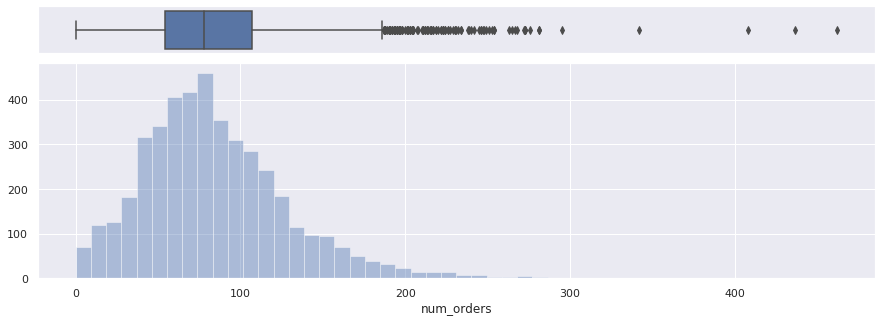

In [17]:
column_info(df, 'num_orders', quantitative=True)

Есть выбросы, исправим их для более "гладкого" обучения.

In [18]:
trimmer(df, 'num_orders')


*** Информация по столбцу num_orders ***

Тип данных столбца num_orders: float64:
В столбце num_orders пропущено 0 из 4416 строк, что составляет 0.00%
Минимальное значение: 0.00
Максимальное значение: 186.00
Среднее значение: 83.38
Медианное значение: 78.00


/home/jovyan/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/jovyan/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


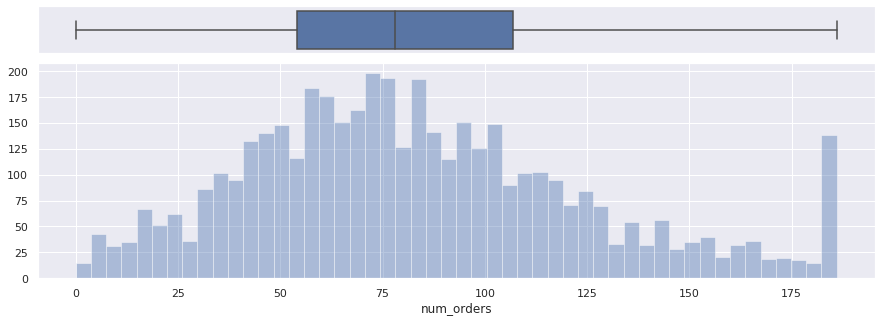

In [19]:
column_info(df, 'num_orders', quantitative=True)

Минивывод: После первой картинки у нас были не большие выбросы, так что их надо было убрать, ради более хорошей работы обучения.

На второй картинке уже результат не много лучше и обучение работает чуть эффективнее.

# 2. Анализ<a id='the_destination02'></a>

Добавим к признакам 20 столбцов с запаздыванием и 4-скользящую среднюю.

In [20]:
make_features(df, 'num_orders', 20, 4, year=False)

Формируем ДФ с разностью значений по суткам, их стандартное отклонение и 25-скользящую среднюю.

In [21]:
df_1D_static = pd.DataFrame(df_1D['num_orders'] - df_1D['num_orders'].shift(), index=df_1D.index)
df_1D_static['mean'] = df_1D_static['num_orders'].rolling(25).mean()
df_1D_static['std'] = df_1D_static['num_orders'].rolling(25).std()

К ДФ по суткам добавляем 25-скользящую среднюю.

In [22]:
make_features(df_1D, 'num_orders', 0, 25, year=False, month=False, day=False, dayofweek=False, hour=False)

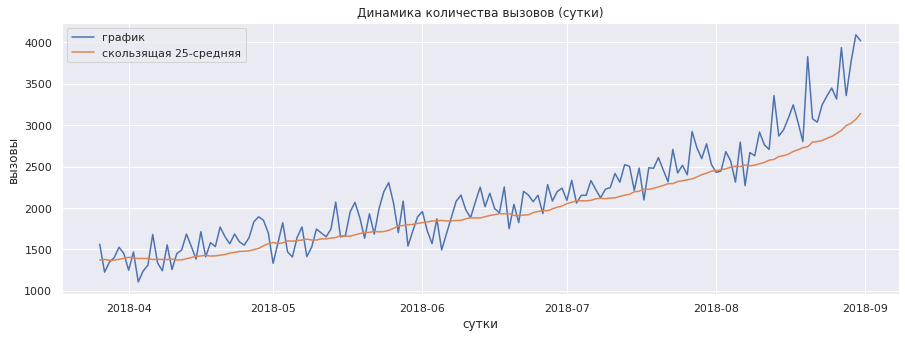

In [23]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
sns.lineplot(data=df_1D, x=df_1D.index, y='num_orders', label='график', ax=ax)
sns.lineplot(data=df_1D, x=df_1D.index, y='rolling_mean_25', label='скользящая 25-средняя', ax=ax)
ax.set_title('Динамика количества вызовов (сутки)')
ax.set_xlabel('сутки')
ax.set_ylabel('вызовы')
plt.show()

График по суткам и его скользящая средняя показывает восходящий тренд. Рассмотрим его подробнее.

<font color='blue'><b>Комментарий ревьювера</b></font> \
<font color='green'>Верно

In [24]:
df_decomposed = seasonal_decompose(df.num_orders)
df_1D_decomposed = seasonal_decompose(df_1D.num_orders)

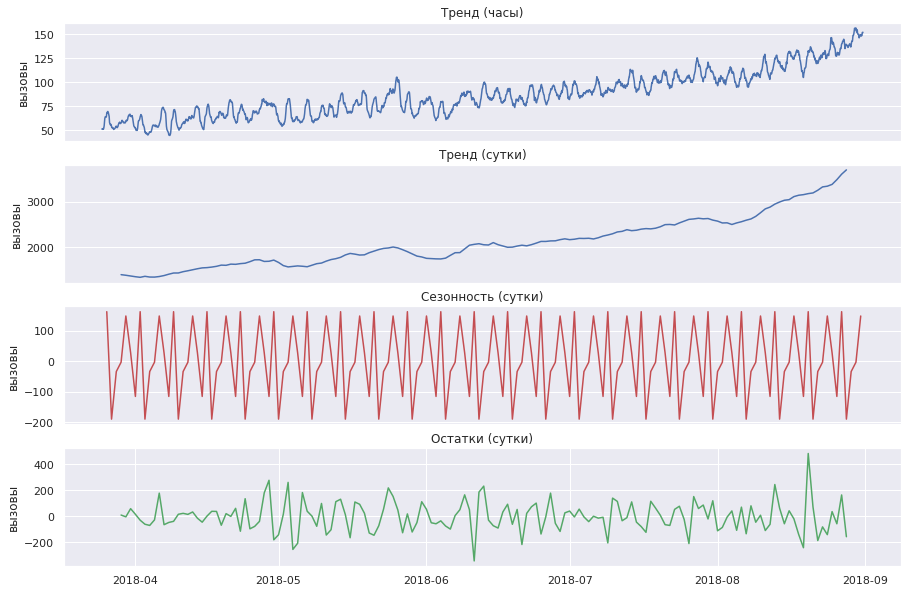

In [25]:
fig = plt.figure(figsize=(15, 10))

ax1 = fig.add_subplot(411)
ax1.plot(df_decomposed.trend['2018-03-25':])
ax1.set_title('Тренд (часы)')
ax1.set_ylabel('вызовы')
ax1.get_xaxis().set_visible(False)

ax2 = fig.add_subplot(412, sharex=ax1)
ax2.plot(df_1D_decomposed.trend)
ax2.set_title('Тренд (сутки)')
ax2.set_ylabel('вызовы')
ax2.get_xaxis().set_visible(False)

ax3 = fig.add_subplot(413, sharex=ax1)
ax3.plot(df_1D_decomposed.seasonal, c='r')
ax3.set_title('Сезонность (сутки)')
ax3.set_ylabel('вызовы')
ax3.get_xaxis().set_visible(False)        

ax4 = fig.add_subplot(414, sharex=ax1)
ax4.plot(df_1D_decomposed.resid, c='g')
ax4.set_title('Остатки (сутки)')
ax4.set_ylabel('вызовы')

plt.show()

Декомпозиция также показывает наличие тренда и сезонности. Рассмотрим сезонность внимательнее.

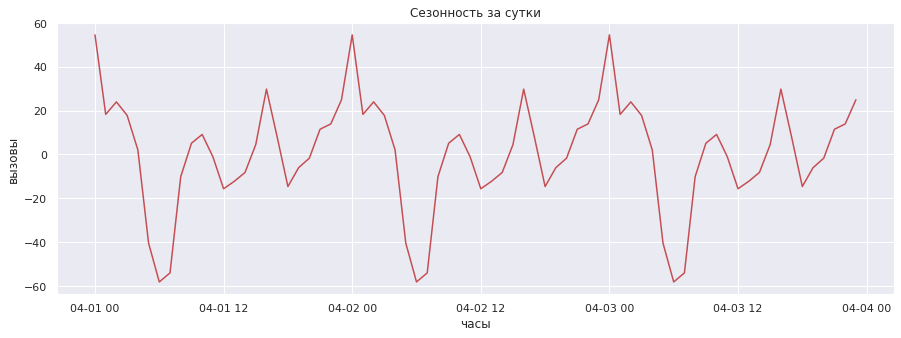

In [26]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
ax.plot(df_decomposed.seasonal['2018-04-01':'2018-04-03'], c='r')
ax.set_title('Сезонность за сутки')
ax.set_xlabel('часы')
ax.set_ylabel('вызовы')
plt.show()

Сезонность носит суточный характер. Минимум заказов около 6 утра, в то время как пик приходится на 12 ночи, когда общественный транспорт прекращает свою работу. Также пики наблюдаются в часы пик: 9 утра и 6 вечера.

Рассмотрим стационарную картину.

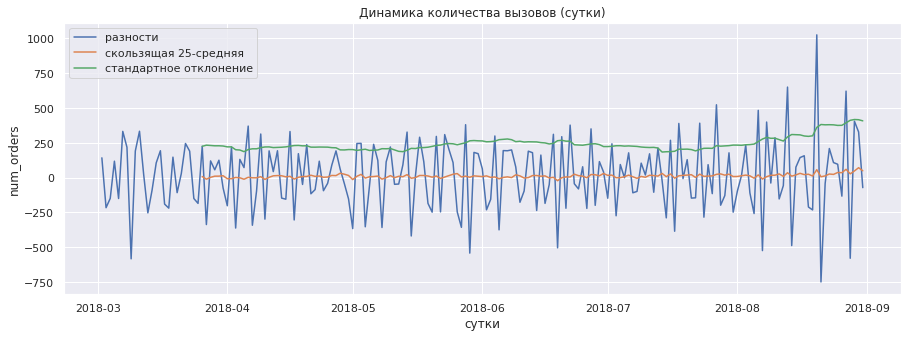

In [27]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
sns.lineplot(data=df_1D_static, x=df_1D_static.index, y='num_orders', label='разности', ax=ax)
sns.lineplot(data=df_1D_static, x=df_1D_static.index, y='mean', label='скользящая 25-средняя', ax=ax)
sns.lineplot(data=df_1D_static, x=df_1D_static.index, y='std', label='стандартное отклонение', ax=ax)
ax.set_title('Динамика количества вызовов (сутки)')
ax.set_xlabel('сутки')
plt.show()

Волатильность несколько возрасла в конце лета, начале осени. Период откусков?

# 3. Подготовка<a id='the_destination03'></a>

Добавим несколько дополнительных скользящих средних. Почему нет? Наблюдаений немного, можно позволить.

In [28]:
df['rolling_mean_4'] = df['num_orders'].rolling(4).mean()
df['rolling_mean_8'] = df['num_orders'].rolling(8).mean()
df['rolling_mean_16'] = df['num_orders'].rolling(16).mean()
df['rolling_mean_32'] = df['num_orders'].rolling(32).mean()
df['rolling_mean_64'] = df['num_orders'].rolling(64).mean()

df.dropna(inplace=True)

Аккуратно делим выборку на тренировочную и тестувую.

In [29]:
train, test = train_test_split(df, shuffle=False, test_size=.1)

Не менее аккуратно пытаемся выделить целевой признак.

In [30]:
train_features = train[0:-1]
train_target = train['num_orders'].shift(-1)
train_target = train_target[0:-1]

test_features = test[0:-1]
test_target = test['num_orders'].shift(-1)
test_target = test_target[0:-1]

Все признаки количественные - можно отмасштабировать.

In [31]:
scaler = MinMaxScaler()

train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

Итоговые объёмы выборок.

In [32]:
train_features.shape

(3898, 30)

In [33]:
train_target.shape

(3898,)

In [34]:
test_features.shape

(433, 30)

In [35]:
test_target.shape

(433,)

# 4. Обучение<a id='the_destination04'></a>

Для градиентного бустинга слишком маленькая выборка, но мы его всё равно попробуем.

Создаём фолды для временного ряда.

In [36]:
tscv = TimeSeriesSplit(n_splits=3)

### 4.1 Ridge<a id='the_destination05'></a>

In [37]:
%%time

rdg = Ridge()

parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

rdg_grid = GridSearchCV(estimator=rdg, param_grid=parameters, cv=tscv, scoring=scorer)
rdg_grid.fit(train_features, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-rdg_grid.best_score_))
print('Лучшие параметры:', rdg_grid.best_params_)

Лучший rmse среди всех параметров: 27.38
Лучшие параметры: {'alpha': 0.0001}
CPU times: user 505 ms, sys: 466 ms, total: 971 ms
Wall time: 967 ms


Это говорит о том, что лучше всего здесь работает линейная регрессия. Видимо, какие-то признаки оказались бесполезными и модель хочет относящиеся к ним коэффициенты обнулить.

In [38]:
rdg = Ridge(alpha=0.0001)
rdg.fit(train_features, train_target)

rdg_predictions = rdg.predict(test_features)

rdg_rsme = mean_squared_error(test_target, rdg_predictions)**.5
print('rdg rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target, rdg.predict(train_features))**.5))
print('rdg rsme на тестовой выборке: {:.2f}'.format(rdg_rsme))

rdg rsme на обучающей выборке: 25.23
rdg rsme на тестовой выборке: 33.89


### 4.1.1 Ridge (poly)

In [39]:
poly = PolynomialFeatures(degree=2)
train_features_poly = poly.fit_transform(train_features)
test_features_poly = poly.transform(test_features)

In [40]:
%%time

rdg_poly = Ridge()

parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

rdg_grid_poly = GridSearchCV(estimator=rdg_poly, param_grid=parameters, cv=tscv, scoring=scorer)
rdg_grid_poly.fit(train_features_poly, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-rdg_grid_poly.best_score_))
print('Лучшие параметры:', rdg_grid_poly.best_params_)

Лучший rmse среди всех параметров: 25.49
Лучшие параметры: {'alpha': 1}
CPU times: user 4.38 s, sys: 4.4 s, total: 8.78 s
Wall time: 8.75 s


In [41]:
rdg_poly = Ridge(alpha=25)
rdg_poly.fit(train_features_poly, train_target)

rdg_poly_predictions = rdg_poly.predict(test_features_poly)

rdg_poly_rsme = mean_squared_error(test_target, rdg_poly_predictions)**.5
print('rdg_poly rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target,
                                                                             rdg_poly.predict(train_features_poly))**.5))
print('rdg_poly rsme на тестовой выборке: {:.2f}'.format(rdg_poly_rsme))

rdg_poly rsme на обучающей выборке: 22.79
rdg_poly rsme на тестовой выборке: 32.39


### 4.2 SVM<a id='the_destination06'></a>

Метод опорных векторов.

In [42]:
%%time

svr = SVR()

parameters = {'kernel': ['linear', 'poly', 'rbf'],
              'gamma': [0.1, 1],
              'C': [0.1, 1]
              }

svr_grid = GridSearchCV(estimator=svr, param_grid=parameters, cv=tscv, scoring=scorer)
svr_grid.fit(train_features, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-svr_grid.best_score_))
print('Лучшие параметры:', svr_grid.best_params_)

Лучший rmse среди всех параметров: 28.37
Лучшие параметры: {'C': 1, 'gamma': 1, 'kernel': 'poly'}
CPU times: user 18.3 s, sys: 204 ms, total: 18.5 s
Wall time: 18.8 s


Самая затратная по вычислительным ресурсам модель, поэтому параметров немного.

In [43]:
svr = SVR(kernel='poly', gamma=1, C=1)
svr.fit(train_features, train_target)

svr_predictions = svr.predict(test_features)

svr_rsme = mean_squared_error(test_target, svr_predictions)**.5
print('svr rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target, svr.predict(train_features))**.5))
print('svr rsme на тестовой выборке: {:.2f}'.format(svr_rsme))

svr rsme на обучающей выборке: 20.57
svr rsme на тестовой выборке: 39.13


### 4.3 KNN <a id='the_destination07'></a>

Метод соседей.

In [44]:
%%time

knn = KNeighborsRegressor()

parameters = {'metric': ['euclidean', 'manhattan', 'chebyshev'],
              'n_neighbors': [5, 10, 15],              
              'weights': ['uniform', 'distance']              
              }

knn_grid = GridSearchCV(estimator=knn, param_grid=parameters, cv=tscv, scoring=scorer)
knn_grid.fit(train_features, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-knn_grid.best_score_))
print('Лучшие параметры:', knn_grid.best_params_)

Лучший rmse среди всех параметров: 27.26
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
CPU times: user 7.53 s, sys: 0 ns, total: 7.53 s
Wall time: 7.58 s


In [45]:
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=10, weights='distance')
knn.fit(train_features, train_target)

knn_predictions = knn.predict(test_features)

knn_rsme = mean_squared_error(test_target, knn_predictions)**.5
print('knn rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target, knn.predict(train_features))**.5))
print('knn rsme на тестовой выборке: {:.2f}'.format(knn_rsme))

knn rsme на обучающей выборке: 0.00
knn rsme на тестовой выборке: 37.16


### 4.4 RFR <a id='the_destination08'></a>

Случайный лес - по идеологии не должен сильно отличаться от градиентного бустинга LightGBM.

In [46]:
%%time

rfr = RandomForestRegressor(random_state=state)

parameters = {'max_depth': [2, 4, 8, 16],
              'min_samples_leaf': [1, 2, 3] 
              }

rfr_grid = GridSearchCV(estimator=rfr, param_grid=parameters, cv=tscv, scoring=scorer)
rfr_grid.fit(train_features, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-rfr_grid.best_score_))
print('Лучшие параметры:', rfr_grid.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

Лучший rmse среди всех параметров: 27.22
Лучшие параметры: {'max_depth': 16, 'min_samples_leaf': 2}
CPU times: user 6.8 s, sys: 0 ns, total: 6.8 s
Wall time: 6.88 s


In [47]:
rfr = RandomForestRegressor(max_depth=16, min_samples_leaf=1, random_state=state)
rfr.fit(train_features, train_target)

rfr_predictions = rfr.predict(test_features)

rfr_rsme = mean_squared_error(test_target, rfr_predictions)**.5
print('rfr rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target, rfr.predict(train_features))**.5))
print('rfr rsme на тестовой выборке: {:.2f}'.format(rfr_rsme))

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rfr rsme на обучающей выборке: 9.82
rfr rsme на тестовой выборке: 31.81


### 4.5 LightGBM<a id='the_destination09'></a>

Далее у меня что то произошло с юпитером и он перестал запускать я

In [ ]:
%%time

lgb = LGBMRegressor()

parameters = {'learning_rate': [0.01, 0.1, 0.5],
              'max_depth': [5, 10, 15],
              'num_leaves': [10, 25, 50]
              }

lgb_grid = GridSearchCV(estimator=lgb, param_grid=parameters, cv=tscv, scoring=scorer)
lgb_grid.fit(train_features, train_target)

print('Лучший rmse среди всех параметров: {:.2f}'.format(-lgb_grid.best_score_))
print('Лучшие параметры:', lgb_grid.best_params_)

Результаты со случайным лесом похожи.

In [ ]:
lgb = LGBMRegressor(learning_rate=0.1, max_depth=15, num_leaves=25)
lgb.fit(train_features, train_target)

lgb_predictions = lgb.predict(test_features)

lgb_rsme = mean_squared_error(test_target, lgb_predictions)**.5
print('lgb rsme на обучающей выборке: {:.2f}'.format(mean_squared_error(train_target, lgb.predict(train_features))**.5))
print('lgb rsme на тестовой выборке: {:.2f}'.format(lgb_rsme))

### 4.6 Dummy<a id='the_destination10'></a>

В качестве болванки используем предыдущие данные. Обычно в быту (прогноз погоды?) это неплохо работает.

In [ ]:
dmy_predictions = test_target.shift()
dmy_predictions.iloc[0] = train_target.iloc[-1]

dmy_rsme = mean_squared_error(test_target, dmy_predictions)**.5

print('dmy rsme на тестовой выборке: {:.2f}'.format(dmy_rsme))

Если всё посчитано правильно, то эта болванка способна выполнить критерии задания.

In [ ]:
# код ревьювера
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
dummy.fit(train_features, train_target)
dummy_pred = dummy.predict(test_features)
dummy_rsme = mean_squared_error(test_target, dummy_pred)**.5

print('Метрика константной модели на тестовой выборке: {:.2f}'.format(dummy_rsme))

# 5. Вывод<a id='the_destination11'></a>

In [ ]:
results = pd.DataFrame({'quality': [rdg_rsme, rdg_poly_rsme, svr_rsme, knn_rsme, rfr_rsme, lgb_rsme, dmy_rsme]},
                       index=['rdg', 'rdg_p', 'svr', 'knn', 'rfr', 'lgb', 'dmy']
                       )

In [ ]:
results.sort_values('quality')

In [ ]:
results.sort_values('quality', inplace=True)

In [ ]:
bar_chart(results.quality, results.index, 'Качество')

Леса победили, градиентный бустинг по лесу по-прежнему хорош как по качеству, так и по времени. Все модели проявили себя лучше чем болванка, но предпочесть стоит LightGBM.

In [ ]:
df_rdg_predicted = pd.DataFrame(rdg_predictions, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
df_rdg_poly_predicted = pd.DataFrame(rdg_poly_predictions, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
df_lgb_predicted = pd.DataFrame(lgb_predictions, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
df_svr_predicted = pd.DataFrame(svr_predictions, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
df_dmy_predicted = pd.DataFrame(dmy_predictions, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
df_1D_rdg_predicted = pd.DataFrame(df_1D_rdg_predicted, index=test[0:-1].index, columns=['num_orders'])

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
sns.lineplot(data=df, x=df.index, y='num_orders', label='график', linewidth=3, ax=ax)
sns.lineplot(data=df_rdg_predicted, x=df_rdg_predicted.index, y='num_orders', label='rdg_pred', dashes=True, ax=ax)
sns.lineplot(data=df_rdg_poly_predicted, x=df_rdg_poly_predicted.index, y='num_orders', label='rdg_poly_pred', ax=ax)
ax.set_xlim(df_rdg_predicted.index.min(), df_1D_rdg_predicted.index.max())
ax.set_title('Сравнение 10%')
ax.set_xlabel('сутки')
ax.set_ylabel('вызовы')
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot()
sns.lineplot(data=df, x=df.index, y='num_orders', label='график', linewidth=2, ax=ax)
sns.lineplot(data=df_lgb_predicted, x=df_lgb_predicted.index, y='num_orders', label='lgb', ax=ax)
sns.lineplot(data=df_svr_predicted, x=df_svr_predicted.index, y='num_orders', label='svr', ax=ax)
sns.lineplot(data=df_dmy_predicted, x=df_dmy_predicted.index, y='num_orders', label='dmy', ax=ax)
ax.set_xlim(df_rdg_predicted.index.min(), '2018-08-18')
ax.set_title('Сравнение 4 суток')
ax.set_xlabel('сутки')
ax.set_ylabel('вызовы')
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
ax.lines[3].set_linestyle("--")
plt.show()

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48